NLP from scratch. Classifying names with a character level RNN

A character level RNN reads words as a series of characters, outputting a prediction and 'hidden state at every step, feeding its previous hidden state into each next level step. Take the final prediction to be the output, which class the word belongs to.

PREPARE THE DATA

in 'data/names' there are 18 text files, with each file having one name per line

In [16]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob # used to find files recursively
import os

In [17]:
def findFiles(path): 
    return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# turn a unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )
print(unicodeToAscii('Ślusàrski'))

# build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

# now have category_lines, a dictionary that maps each language to a list of names.
# all_categories is a list of each language


['data/names/Czech.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/Polish.txt']
Slusarski


In [18]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


TURNING NAMES TO TENSORS

now that the names are organized, we need to turn them into tensors

to represent a single letter, use a one hot vector of size <1 * n_letters>, ( all 0's bar the the index of the current letter)

to represent we join the vectors into a 2d matrix <line_length * 1 * n_letters>
         -> [[1,0,0,0], [0,1,0,0],[1,0,0,0]]

The extra dimension is because pytorch expects everything in batches, above batch = 1.

In [19]:
import torch

# find letter index from all_letters, a = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# for a demo, turn a letter into a <1 * n_letters> tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# turn a line into an array of one hot vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


CREATE THE NETWORK

creating a RNN with two linear layers that operate on an input and hidden state, with a LogSoftmax layer after the output

In [20]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128

rnn = RNN(n_letters, n_hidden, n_categories)

to run a step of the network we need to pass an input (in this case a tensor for the current letter.) and a previous hidden state ( initialize with 0's first).

in return we get the output ( probability of each language) and the next hidden state ( keep for the next step)

In [21]:
input = letterToTensor('A')

hidden = torch.zeros(1,n_hidden)

output, next_hidden = rnn(input, hidden)

for the sake of efficeincy use lineToTensor so we are not creating a new tensor for every step and use slices

In [22]:
input = lineToTensor('Albert')

hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)

print(output)

# the tensor returned is a <1 * n_categories> tensor, with a likelihood for each category

tensor([[-2.9067, -2.8175, -2.9936, -2.8766, -2.8222, -2.8651, -2.8589, -3.0129,
         -2.9855, -2.8558, -2.9065, -2.8043, -2.8435, -2.8883, -2.8725, -2.9875,
         -2.8996, -2.8632]], grad_fn=<LogSoftmaxBackward0>)


TRAINING
 
 before training create some  helper functions. firstly one to interpret the output of the network, which is the likelihood of each category.
 use Tensor.topk to get the index of greatest value. 

In [23]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Greek', 11)


In [24]:
# also want a quick way of getting a training example (name and its language)
import random 

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTraingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for ii in range(10):
    category, line, category_tensor, line_tensor = randomTraingExample()
    print('category =', category, '/ line=',)



category = Russian / line=
category = Korean / line=
category = Scottish / line=
category = Polish / line=
category = Irish / line=
category = Czech / line=
category = Chinese / line=
category = Greek / line=
category = Russian / line=
category = Scottish / line=


TRAINING THE NETWORK

train the network with the training set

In [25]:
# for the loss function nn.NLLLoss is appropiate, as the last layer of the RNN is nn.LogSoftmax

criterion = nn.NLLLoss()

each loop of training will:
- create input and target tensors
- create a zeroed initial hidden state
- read each letter in and keep the hidden state for the next letter
- compare final output to target
- backpropogate
- return the output and loss

In [26]:
learning_rate = 0.005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    
    rnn.zero_grad()

    for ii in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[ii], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # add parameters gradients to their values, multiplied by learning rate
    for pp in rnn.parameters():
        pp.data.add_(pp.grad.data, alpha=-learning_rate)

    return output, loss.item()

since the train function returns both the output and loss we can print its guesses and also keep track of loss for plotting.

since there are 1000's of examples print only every 'print_every' and take an average of the loss

In [27]:
import time 
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s -= m * 60
    return '%dm %ds' % (m,s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTraingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # print iter number, loss, name and guess

    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = 'Correct' if guess == category else 'Incorrect (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss/ plot_every)
        current_loss = 0

5000 5% (0m 1s) 2.9477 Nunes / Greek Incorrect (Portuguese)
10000 10% (0m 3s) 2.9975 Cruz / Korean Incorrect (Portuguese)
15000 15% (0m 5s) 2.1349 Gomes / Czech Incorrect (Portuguese)
20000 20% (0m 7s) 2.0484 Urogataya / Irish Incorrect (Japanese)
25000 25% (0m 8s) 0.4185 Belesis / Greek Correct
30000 30% (0m 10s) 1.6394 Sokal / Arabic Incorrect (Polish)
35000 35% (0m 12s) 1.4905 Jindra / Czech Correct
40000 40% (0m 14s) 1.8855 Melo / Spanish Incorrect (Portuguese)
45000 45% (0m 16s) 1.3476 Tannous / Portuguese Incorrect (Arabic)
50000 50% (0m 17s) 0.9696 Petit / French Correct
55000 55% (0m 19s) 1.1693 Zimmermann / Dutch Incorrect (German)
60000 60% (0m 21s) 0.8911 Madden / Irish Correct
65000 65% (0m 23s) 0.1553 Wan / Chinese Correct
70000 70% (0m 24s) 0.7040 Ramsay / Scottish Correct
75000 75% (0m 26s) 0.2243 Pham / Vietnamese Correct
80000 80% (0m 28s) 2.0686 Abeln / Dutch Incorrect (German)
85000 85% (0m 30s) 3.1817 Sedmikova / Japanese Incorrect (Czech)
90000 90% (0m 32s) 1.3531 

PLOT THE RESULTS

plotting the historical loss from all_losses shows the network learning

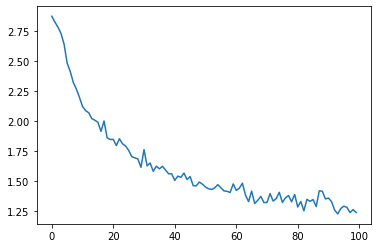

In [28]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

EVALUATING THE RESULTS

create a confusion matrix to see how well the network performs on different categories.

this shows for every actual language (rows) which the language guesses (columns).

to calculate the confusion matrix a bunch of samples are run through the network with evaluate(), which is same as train() without the backprop

/var/folders/nv/lzp9ffbj6cs24kjrpcj0q1ym0000gn/T/ipykernel_14644/1004437678.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation = 90)
/var/folders/nv/lzp9ffbj6cs24kjrpcj0q1ym0000gn/T/ipykernel_14644/1004437678.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


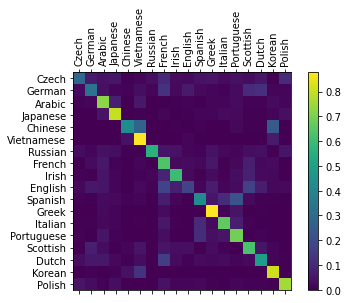

In [33]:
# keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for ii in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[ii], hidden)

    return output

# go through a bunch of examples and record which ones are correctly guessed
for ii in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTraingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# normalize by dividing every row by its sum
for ii in range(n_categories):
    confusion[ii] = confusion[ii] / confusion[ii].sum()

# set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# set up the axes
ax.set_xticklabels([''] + all_categories, rotation = 90)
ax.set_yticklabels([''] + all_categories)

# force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

# pick off brigt spots off the axis to show which languages it guesses incorrectly, e.g. Chinese for Korean, Spanish for Portugese

RUNNING ON USER INPUT